In [53]:
import pandas as pd
import os
import zipfile
import glob
from pathlib import Path
import calendar
from datetime import datetime

As mentioned during the meeting, the dataset includes phone checks of 10K users in the time between 2016 and 2019. 
 
Each user has been selected with the following inclusion criteria:
-	Active for at least 6 months (a month is here considered as 30 days)
-	Having at least 90% coverage (i.e. being active at least 90% of the days in the time span)
 
The dataset is stored in parquet files (about 3GB accessible via pandas read_parquet function or pyspark) and it is in the form of a dataframe having 3 columns:
-	user_id (int): number between 0-9999 indicating the id of a user;
-	start_time_unix (timestamp): unix timestamp indicating the starting time of a phone check;
-	end_time_unix (timestamp): unix timestamp indicating the ending time of a phone check.

### Reading the data

In [21]:
fileName = 'data_for_AsteriosIlektra'
filePath = os.path.abspath(os.path.join(os.getcwd(), fileName))
data_dir = Path(filePath)

In [22]:
full_df = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('*.parquet')
)
#full_df.to_csv('csv_file.csv')

#### New dataset, user id and how many times have opened their phone generally

In [23]:
users_times_accessed = pd.DataFrame(full_df.groupby(['user_id'])['start_time_unix'].count())

### Making new features

#### Year, month, days (numeric and strings) etc.

In [24]:
full_df['start_time'] = pd.to_datetime(full_df['start_time_unix'], unit='s', origin='unix')
full_df['end_time'] = pd.to_datetime(full_df['end_time_unix'], unit='s', origin='unix')

In [25]:
#pd.to_datetime(full_df['start_time_unix']).dt.year.unique()

In [26]:
full_df['year'] = pd.to_datetime(full_df['start_time']).dt.year
full_df['month'] = pd.to_datetime(full_df['start_time']).dt.month
full_df['weekday'] = pd.to_datetime(full_df['start_time']).dt.weekday # monday is 0
full_df['day'] = pd.to_datetime(full_df['start_time']).dt.day
full_df['Day'] = pd.to_datetime(full_df['start_time']).dt.strftime('%A') #day numeric
full_df['hour'] = pd.to_datetime(full_df['start_time']).dt.hour
full_df['minute'] = pd.to_datetime(full_df['start_time']).dt.minute
full_df['second'] = pd.to_datetime(full_df['start_time']).dt.second

In [27]:
full_df

,start_time_unix,end_time_unix,user_id,start_time,end_time,year,month,weekday,day,hour,minute,second
0,1509974112,1509974166,8953,2017-11-06 13:15:12,2017-11-06 13:16:06,2017,11,0,6,13,15,12
1,1485290512,1485291345,3633,2017-01-24 20:41:52,2017-01-24 20:55:45,2017,1,1,24,20,41,52
2,1542211846,1542211886,3633,2018-11-14 16:10:46,2018-11-14 16:11:26,2018,11,2,14,16,10,46
3,1545775959,1545775979,3633,2018-12-25 22:12:39,2018-12-25 22:12:59,2018,12,1,25,22,12,39
4,1503749278,1503749288,3633,2017-08-26 12:07:58,2017-08-26 12:08:08,2017,8,5,26,12,7,58
...,...,...,...,...,...,...,...,...,...,...,...,...
727777,1508853633,1508853643,4117,2017-10-24 14:00:33,2017-10-24 14:00:43,2017,10,1,24,14,0,33
727778,1499472387,1499472397,4117,2017-07-08 00:06:27,2017-07-08 00:06:37,2017,7,5,8,0,6,27
727779,1503680264,1503680328,4117,2017-08-25 16:57:44,2017-08-25 16:58:48,2017,8,4,25,16,57,44
727780,1503485213,1503485222,4117,2017-08-23 10:46:53,2017-08-23 10:47:02,2017,8,2,23,10,46,53


In [28]:
# to right order day strings
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
full_df['Day'] = pd.Categorical(full_df['Day'], categories=cats, ordered=True)

# to change month into month strings
full_df['Month'] = full_df['month'].apply(lambda x: calendar.month_abbr[x])
cats = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',  'Jul', 'Aug', 'Sep', 'Oct', 'Nov','Dec',]
full_df['Month'] = pd.Categorical(full_df['Month'], categories=cats, ordered=True)

#### Duration between sessions

In [84]:
full_df['duration'] = full_df['end_time'] - full_df['start_time']
#full_df['duration_in_seconds'] = full_df['duration'].apply( lambda x: x.seconds)

In [85]:
def days_hours_minutes_seconds(td):
    return td.days, td.seconds//3600, (td.seconds//60)%60, td.seconds


days_hours_minutes_seconds(full_df.iloc[0]['duration'])

(0, 0, 0, 54)

In [86]:
full_df

,start_time_unix,end_time_unix,user_id,start_time,end_time,year,month,weekday,day,hour,minute,second,DayOfWeek,Month,duration
0,1509974112,1509974166,8953,2017-11-06 13:15:12,2017-11-06 13:16:06,2017,11,0,6,13,15,12,NaN,Nov,0 days 00:00:54
1,1485290512,1485291345,3633,2017-01-24 20:41:52,2017-01-24 20:55:45,2017,1,1,24,20,41,52,NaN,Jan,0 days 00:13:53
2,1542211846,1542211886,3633,2018-11-14 16:10:46,2018-11-14 16:11:26,2018,11,2,14,16,10,46,NaN,Nov,0 days 00:00:40
3,1545775959,1545775979,3633,2018-12-25 22:12:39,2018-12-25 22:12:59,2018,12,1,25,22,12,39,NaN,Dec,0 days 00:00:20
4,1503749278,1503749288,3633,2017-08-26 12:07:58,2017-08-26 12:08:08,2017,8,5,26,12,7,58,NaN,Aug,0 days 00:00:10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727777,1508853633,1508853643,4117,2017-10-24 14:00:33,2017-10-24 14:00:43,2017,10,1,24,14,0,33,NaN,Oct,0 days 00:00:10
727778,1499472387,1499472397,4117,2017-07-08 00:06:27,2017-07-08 00:06:37,2017,7,5,8,0,6,27,NaN,Jul,0 days 00:00:10
727779,1503680264,1503680328,4117,2017-08-25 16:57:44,2017-08-25 16:58:48,2017,8,4,25,16,57,44,NaN,Aug,0 days 00:01:04
727780,1503485213,1503485222,4117,2017-08-23 10:46:53,2017-08-23 10:47:02,2017,8,2,23,10,46,53,NaN,Aug,0 days 00:00:09


In [87]:
full_df.groupby(['user_id', 'year', 'month', 'weekday'])['duration'].sum()

user_id  year  month  weekday
0        2016  7      0         0 days 09:24:30
                      1         0 days 10:49:23
                      2         0 days 08:52:00
                      3         0 days 11:42:35
                      4         0 days 10:33:09
                                      ...      
9999     2018  11     2         0 days 10:41:13
                      3         0 days 10:17:54
                      4         0 days 05:39:10
                      5         0 days 09:34:49
                      6         0 days 09:46:16
Name: duration, Length: 995775, dtype: timedelta64[ns]

In [88]:
full_df.groupby(['user_id', 'weekday'])['duration'].sum()

user_id  weekday
0        0         3 days 00:05:04
         1         3 days 03:31:59
         2         2 days 16:49:11
         3         2 days 17:08:36
         4         2 days 19:30:53
                         ...      
9999     2         7 days 20:03:40
         3         7 days 17:36:47
         4         7 days 00:38:57
         5         6 days 03:28:26
         6         6 days 19:04:59
Name: duration, Length: 70000, dtype: timedelta64[ns]

In [90]:
weekly_overall_duration = full_df.groupby(['weekday'])['duration'].sum()

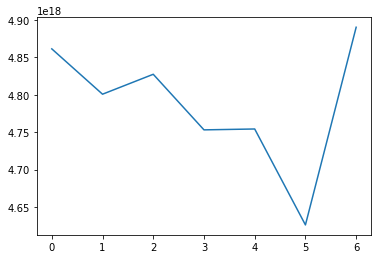

In [96]:
import matplotlib.pyplot as plt 

plt.plot(weekly_overall_duration)
plt.show()

/home/s202242/.conda/envs/advancedproject/lib/python3.9/site-packages/matplotlib/axes/_base.py:507: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


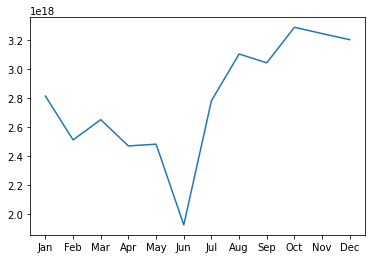

In [97]:
monthly_overall_duration = full_df.groupby(['Month'])['duration'].sum()

plt.plot(monthly_overall_duration)
plt.show()

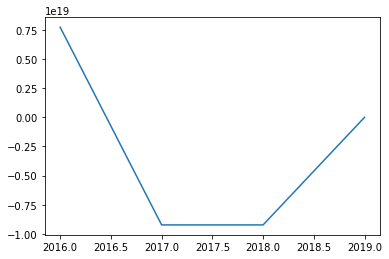

In [98]:
yearly_overall_duration = full_df.groupby(['year'])['duration'].sum()


plt.plot(yearly_overall_duration)
plt.show()

In [99]:
yearly_overall_duration

year
2016   89386 days 20:50:28
2017                   NaT
2018                   NaT
2019       0 days 03:32:13
Name: duration, dtype: timedelta64[ns]

In [ ]:
full_df.groupby(['year']).sum()